In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
from tqdm.notebook import tqdm
import numpy as np
import scipy

sigmoid = lambda x: 1 / (1 + np.exp(-x))

y = []
for path, dirs, files in os.walk(os.path.join('data', 'training', 'qlds_2022a', 'X_label')):
    pbar = tqdm(files)
    for filename in pbar:
        code = filename.split('.')[0].split('_')[-2]
        name = filename.split('.')[0].split('_')[-1]
        pbar.set_description(code)
        file_path = os.path.join(path, filename)
        X_label = np.load(file_path)
        
        _y = sigmoid((X_label[:, 0] * 0.5 + X_label[:, 1] * 0.3 + X_label[:, 2] * 0.2) * 3)
        y.extend(_y)

        file_path = os.path.join('data', 'training', 'qlds_2022a', 'y', f'y_{code}_{name}.npy')
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        np.save(file_path, _y)

scipy.stats.describe(y)

  0%|          | 0/2327 [00:00<?, ?it/s]

DescribeResult(nobs=3488682, minmax=(0.18921474526394863, 0.847763422421168), mean=0.49919003189051064, variance=0.0033494127723283553, skewness=-1.1412328575206214, kurtosis=2.0154585241432867)

In [32]:
input_dim = 0
for path, dirs, files in os.walk(os.path.join('data', 'training', 'qlds_2022a', 'X')):
    for filename in files:
        file_path = os.path.join(path, filename)
        X = np.load(file_path)
        print(X.shape)
        input_dim = X.shape[1]
        break

(1782, 435)


In [33]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid(),
)
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)
model.apply(init_weights)
model.to(device)

Sequential(
  (0): Linear(in_features=435, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=32, out_features=1, bias=True)
  (13): Sigmoid()
)

In [40]:
for epoch in tqdm(range(10)):
    for path, dirs, files in os.walk(os.path.join('data', 'training', 'qlds_2022a', 'X')):
        loss = 0
        for filename in tqdm(files):
            code = filename.split('.')[0].split('_')[-2]
            name = filename.split('.')[0].split('_')[-1]
            file_path = os.path.join(path, filename)
            X = np.load(file_path)
            file_path = os.path.join(os.path.dirname(path), 'y', f'y_{code}_{name}.npy')
            y = np.load(file_path)
            X = torch.from_numpy(X).float().to(device)
            y = torch.from_numpy(y).float().to(device)
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
            optimizer.zero_grad()
            y_pred = model(X)
            _loss = criterion(y_pred[:, 0], y)
            _loss.backward()
            optimizer.step()
            _loss = _loss.item()
            loss += _loss
        print(f'epoch={epoch}\tloss={loss}')

os.makedirs('models', exist_ok=True)
path = os.path.join('models', 'model.mdl')
torch.save(model, path)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=0	loss=5.6357756288780365


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=1	loss=5.553984031372238


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=2	loss=5.493619897693861


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=3	loss=5.401611910849169


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=4	loss=5.281618339283341


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=5	loss=5.340227730634069


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=6	loss=5.368605248710082


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=7	loss=5.299149343729368


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=8	loss=5.282565782996244


  0%|          | 0/2327 [00:00<?, ?it/s]

epoch=9	loss=5.292827067409235


  0%|          | 0/2327 [00:00<?, ?it/s]

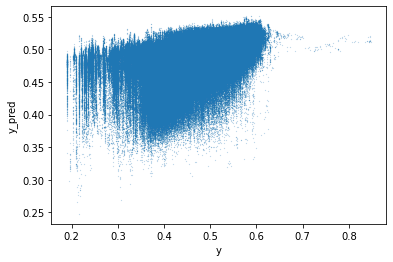

In [41]:
import torch

path = os.path.join('models', 'model.mdl')
model = torch.load(path)

y = []
y_pred = []
for path, dirs, files in os.walk(os.path.join('data', 'training', 'qlds_2022a', 'X')):
    loss = 0
    for filename in tqdm(files):
        code = filename.split('.')[0].split('_')[-2]
        name = filename.split('.')[0].split('_')[-1]
        file_path = os.path.join(path, filename)
        X = np.load(file_path)
        file_path = os.path.join(os.path.dirname(path), 'y', f'y_{code}_{name}.npy')
        _y = np.load(file_path)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        with torch.no_grad():
            X = torch.from_numpy(X).float().to(device)
            pred = model(X).detach().cpu().numpy()
            pred = pred.flatten()
        
        y.extend(_y)
        y_pred.extend(pred)

import pandas as pd
df_eval = pd.DataFrame(list(zip(y, y_pred)), columns=['y', 'y_pred'])
ax = df_eval.plot.scatter('y', 'y_pred', s=0.01)

In [42]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y, y_pred)}')

MSE: 0.0026148916159384017


  0%|          | 0/2400 [00:00<?, ?it/s]

<AxesSubplot:xlabel='y', ylabel='y_pred'>

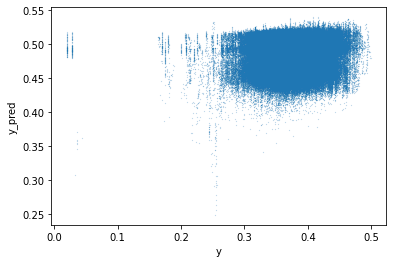

In [45]:
y_test = []
y_pred_test = []
for path, dirs, files in os.walk(os.path.join('data', 'testing', 'qlds_2022a', 'X')):
    loss = 0
    for filename in tqdm(files):
        code = filename.split('.')[0].split('_')[-2]
        name = filename.split('.')[0].split('_')[-1]
        file_path = os.path.join(path, filename)
        X = np.load(file_path)
        file_path = os.path.join(os.path.dirname(path), 'y', f'y_{code}_{name}.npy')
        _y = np.load(file_path)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        with torch.no_grad():
            X = torch.from_numpy(X).float().to(device)
            pred = model(X).detach().cpu().numpy()
            pred = pred.flatten()
        
        y_test.extend(_y)
        y_pred_test.extend(pred)

import pandas as pd
df_eval_test = pd.DataFrame(list(zip(y_test, y_pred_test)), columns=['y', 'y_pred']).dropna()
df_eval_test.plot.scatter('y', 'y_pred', s=0.01)

In [46]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, y_pred_test)}')

MSE: 0.015103724324432386
